In [6]:
%store -r df
%store -r KEYWORDS
%store -r noisy_punct
%store -r ks
%store -r map_
%store -r indices_of_first_attempts_per_user
%store -r sorted_users
%store -r INDICES
%store -r recipes_indices

In [7]:
import import_ipynb

from RevisionsStudy import *

import numpy as np
import pandas as pd
import os
import pm4py
from pm4py.visualization.petri_net import  visualizer as pn_vis_factory
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import  algorithm as alpha_miner

%store -r sorted_users
%store -r df

In [19]:
def save_directly_follow_graph(csv_filepath, group_num):
    dataframe = pd.read_csv(csv_filepath, sep=';')
    event_log = pm4py.format_dataframe(dataframe, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
    event_log = pm4py.convert_to_event_log(dataframe)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
    try:
        pm4py.save_vis_performance_dfg(performance_dfg, start_activities, end_activities, 'results/process mining/groupnum{n}.png'.format(n=group_num))
    except: 
        print('user only has 1 recipe')

In [20]:
ACTIONS = [';1st recipe submitted;', ';revision;', ';second recipe submitted;']
def format_user_data(user_index, case_id=1):
    recipe_indices = map_[user_index].copy()
    if user_index == len(sorted_users) - 1: last_index_where_written = len(df)
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)

    where_in_df = np.where(df['user_id'] == sorted_users[user_index])
    first_index = where_in_df[0][0]

    first_line = str(case_id) + ACTIONS[0] + df.iloc[where_in_df[0][0]]['event_date']             
    lines = [first_line]
    for i, index in enumerate(range(recipe_indices[0]+1, recipe_indices[-1]+1)):
        j = index
        is_new_recipe = index in recipe_indices
        while not is_new_recipe:
            line = ACTIONS[1] + df.iloc[where_in_df[0][i+1]]['event_date']
            lines.append(line)
            j+=1
            if j in recipe_indices: is_new_recipe = True
        try:
            if index in recipe_indices : lines.append(ACTIONS[2] + df.iloc[where_in_df[0][i+1]]['event_date'])
        except: continue
        
    result = lines
    for i, line in enumerate(lines):
        if line.startswith(ACTIONS[1]):
            result[i] = str(case_id) + line
           
        elif line.startswith(ACTIONS[2]):
            second_recipe_already_submitted = any([ACTIONS[2] in l for l in result[:i]])
            if second_recipe_already_submitted:
                result[i] = str(case_id) + line.replace('second', 'third') 
            else : result[i] = str(case_id) + line
        
    for i, line in enumerate(result):
        replaced = ACTIONS[2].replace('second', 'third')
        if line.startswith(str(case_id) + replaced):
            has_submitted_third_recipe = any([replaced in l for l in result[:i]])
            if has_submitted_third_recipe:
                result[i] =";;"
            else : result[i] = line 
            
    return  pd.DataFrame(sorted(set(result), key=result.index), columns=['case_id;activity;timestamp'])

In [21]:
for i in range(0,2):
    dframes = []
    for j, user in enumerate(INDICES[i]):
        A = format_user_data(user_index=user, case_id=j+1)
        dframes.append(A)

    res = pd.concat(dframes)
    path = 'data/processMiningData/group{i}.csv'.format(i=i+1)
    res.to_csv(path, index=False)
    save_directly_follow_graph(csv_filepath=path, group_num=i+1)

C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pm4py\utils.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pm4py\utils.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[xes_constants.DEFAULT_

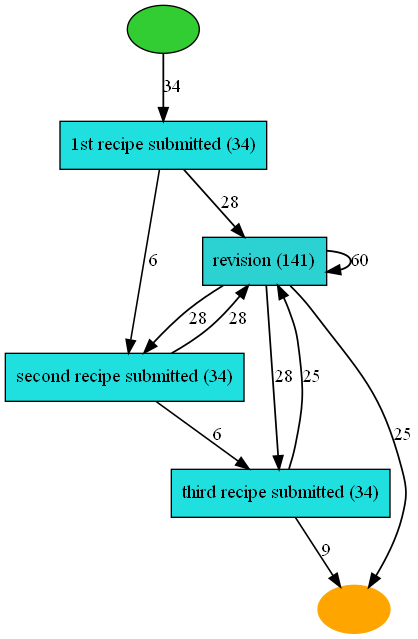

In [33]:
dataframe = pd.read_csv("data/processMiningData/group1.csv", sep=';')
event_log = pm4py.format_dataframe(dataframe, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
event_log = pm4py.convert_to_event_log(dataframe)
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.8)

tree = pm4py.discover_process_tree_inductive(event_log)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(tree)
pm4py.view_heuristics_net(heu_net)